데이터 로드 중...
학습 데이터 크기: (87159, 16)
테스트 데이터 크기: (46204, 15)
제출 샘플 크기: (46204, 2)

학습 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87159 entries, 0 to 87158
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 87159 non-null  object 
 1   Age                87159 non-null  int64  
 2   Gender             87159 non-null  object 
 3   Country            87159 non-null  object 
 4   Race               87159 non-null  object 
 5   Family_Background  87159 non-null  object 
 6   Radiation_History  87159 non-null  object 
 7   Iodine_Deficiency  87159 non-null  object 
 8   Smoke              87159 non-null  object 
 9   Weight_Risk        87159 non-null  object 
 10  Diabetes           87159 non-null  object 
 11  Nodule_Size        87159 non-null  float64
 12  TSH_Result         87159 non-null  float64
 13  T4_Result          87159 non-null  float64
 14  T3_Result          87159 n

,Description,Value
0,Session id,42
1,Target,Cancer
2,Target type,Binary
3,Original data shape,"(69727, 16)"
4,Transformed data shape,"(106821, 29)"
5,Transformed train set shape,"(85902, 29)"
6,Transformed test set shape,"(20919, 29)"
7,Numeric features,6
8,Categorical features,9
9,Preprocess,True



모든 모델 학습 및 비교 중...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8843,0.7054,0.4292,0.5216,0.4708,0.4066,0.4091,0.8200
gbc,Gradient Boosting Classifier,0.8840,0.7033,0.4287,0.5201,0.4700,0.4056,0.4080,2.7100
rf,Random Forest Classifier,0.8817,0.7008,0.3505,0.5101,0.4155,0.3522,0.3599,1.1320
catboost,CatBoost Classifier,0.8834,0.7030,0.3454,0.5208,0.4153,0.3535,0.3627,3.6960
et,Extra Trees Classifier,0.8790,0.6962,0.3439,0.4939,0.4054,0.3404,0.3474,0.9100
lda,Linear Discriminant Analysis,0.8536,0.6882,0.3893,0.3900,0.3895,0.3064,0.3064,0.2440
ridge,Ridge Classifier,0.8187,0.6866,0.4458,0.3178,0.3711,0.2686,0.2738,0.2260
ada,Ada Boost Classifier,0.8565,0.6842,0.3425,0.3950,0.3640,0.2841,0.2864,0.7500
nb,Naive Bayes,0.8135,0.6829,0.4007,0.2959,0.3403,0.2346,0.2383,0.2420
lr,Logistic Regression,0.7486,0.6834,0.5242,0.2447,0.3335,0.2031,0.2256,0.8420



최고 성능 모델: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

최고 모델 분석 중...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


최고 모델 하이퍼파라미터 튜닝 중...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8855,0.6983,0.4637,0.5257,0.4927,0.4285,0.4295
1,0.8819,0.6953,0.4548,0.5091,0.4804,0.4140,0.4148
2,0.8811,0.6900,0.4275,0.5055,0.4632,0.3969,0.3987
3,0.8872,0.7098,0.4936,0.5322,0.5122,0.4485,0.4489
4,0.8867,0.7234,0.4808,0.5306,0.5045,0.4407,0.4414
Mean,0.8845,0.7034,0.4641,0.5206,0.4906,0.4257,0.4267
Std,0.0025,0.0119,0.0227,0.0111,0.0174,0.0185,0.0181


Fitting 5 folds for each of 10 candidates, totalling 50 fits

튜닝된 모델 평가 중...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


모델 해석 중...


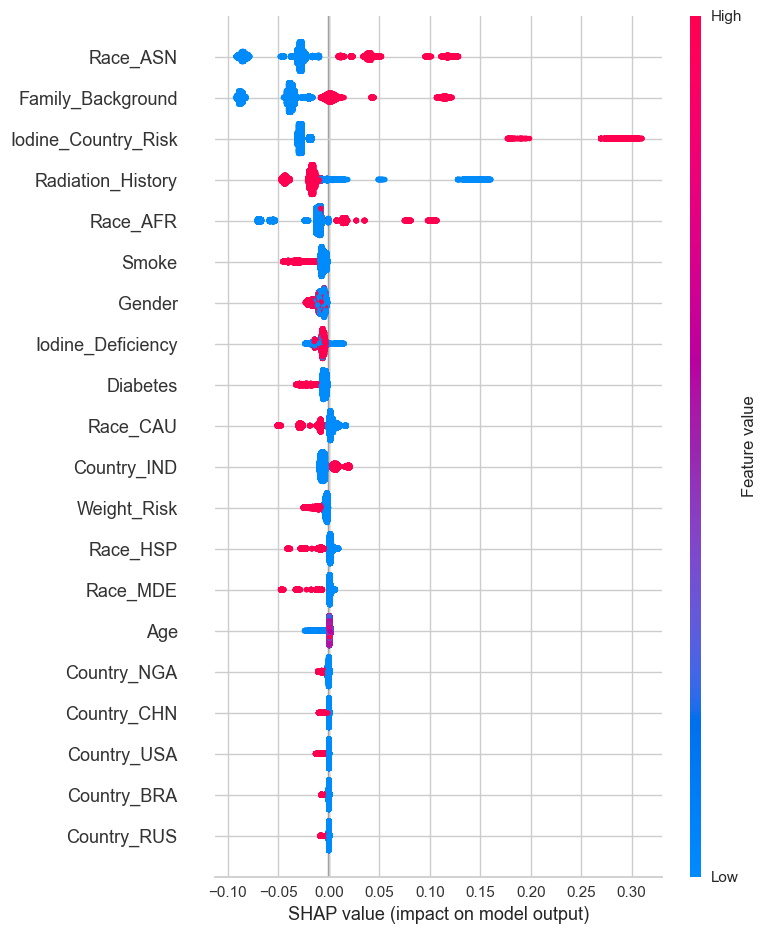


전체 데이터를 사용하여 최종 모델 생성 중...


,Description,Value
0,Session id,42
1,Target,Cancer
2,Target type,Binary
3,Original data shape,"(87159, 16)"
4,Transformed data shape,"(133528, 29)"
5,Transformed train set shape,"(107380, 29)"
6,Transformed test set shape,"(26148, 29)"
7,Numeric features,6
8,Categorical features,9
9,Preprocess,True


튜닝된 모델의 파라미터로 전체 데이터에서 다시 학습 중...
모델 생성 중 오류 발생: Estimator LGBMClassifier not available. Please see docstring for list of available estimators.
기본 모델로 대체합니다.


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:02:30
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# PyCaret 라이브러리 임포트
from pycaret.classification import *

# 데이터 로드
print("데이터 로드 중...")
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')
sample_submission = pd.read_csv('../sample_submission.csv')

print(f"학습 데이터 크기: {train_df.shape}")
print(f"테스트 데이터 크기: {test_df.shape}")
print(f"제출 샘플 크기: {sample_submission.shape}")

# 기본적인 데이터 정보 확인
print("\n학습 데이터 정보:")
print(train_df.info())

print("\n결측치 확인:")
print(train_df.isnull().sum())

# 타겟 변수 분포 확인
print("\n타겟 변수(Cancer) 분포:")
print(train_df['Cancer'].value_counts())
print(f"암 양성 비율: {train_df['Cancer'].mean() * 100:.2f}%")

# 1. 데이터 전처리
print("\n데이터 전처리 진행 중...")

# ID 열 drop
train_df_processed = train_df.drop('ID', axis=1)
test_df_processed = test_df.drop('ID', axis=1)

# 범주형(문자열) 변수와 수치형 변수 분리
categorical_cols = train_df_processed.select_dtypes(include=['object']).columns
numerical_cols = train_df_processed.select_dtypes(exclude=['object']).columns.drop('Cancer')

print(f"\n범주형 변수: {list(categorical_cols)}")
print(f"수치형 변수: {list(numerical_cols)}")

# 2. 간단한 특성 엔지니어링
print("\n특성 엔지니어링 진행 중...")

# 아이오딘 결핍과 국가 상호작용 특성 생성
train_df_processed['Iodine_Country_Risk'] = ((train_df_processed['Iodine_Deficiency'] == 'Deficient') & 
                                            (train_df_processed['Country'] == 'IND')).astype(int)
test_df_processed['Iodine_Country_Risk'] = ((test_df_processed['Iodine_Deficiency'] == 'Deficient') & 
                                           (test_df_processed['Country'] == 'IND')).astype(int)

# 수치형 변수의 이상치 클리핑
for col in numerical_cols:
    q1 = train_df_processed[col].quantile(0.01)
    q3 = train_df_processed[col].quantile(0.99)
    train_df_processed[col] = train_df_processed[col].clip(q1, q3)
    test_df_processed[col] = test_df_processed[col].clip(q1, q3)

# StandardScaler 적용
print("\nStandardScaler 적용 중...")
scaler = StandardScaler()
train_df_processed[numerical_cols] = scaler.fit_transform(train_df_processed[numerical_cols])
test_df_processed[numerical_cols] = scaler.transform(test_df_processed[numerical_cols])

# 학습 데이터와 검증 데이터 분리 (20%)
# 나중에 최종 모델 훈련 시 전체 데이터를 사용할 것이므로, 여기서는 모델 비교와 튜닝을 위해 분리
train_data, val_data = train_test_split(train_df_processed, test_size=0.2, random_state=42, stratify=train_df_processed['Cancer'])

print(f"학습 데이터 크기: {train_data.shape}")
print(f"검증 데이터 크기: {val_data.shape}")

# 3. PyCaret 설정 및 모델 비교
print("\nPyCaret으로 여러 모델 비교 중...")

# PyCaret 세션 초기화
clf = setup(
    data=train_data,  # 학습 데이터
    target='Cancer',  # 타겟 변수
    numeric_features=list(numerical_cols) + ['Iodine_Country_Risk'],  # 수치형 변수
    categorical_features=list(categorical_cols),  # 범주형 변수
    ignore_features=['ID'] if 'ID' in train_data.columns else [],  # 무시할 변수
    normalize=False,  # 이미 StandardScaler 적용했으므로 False로 설정
    transformation=True,  # 데이터 변환 수행
    fix_imbalance=True,  # 클래스 불균형 처리
    session_id=42,  # 랜덤 시드
    fold=5,  # 5-폴드 교차 검증
    verbose=True  # 세부 정보 출력
)

# 모든 모델 비교 - 기본 설정으로 모든 모델 학습 및 평가
print("\n모든 모델 학습 및 비교 중...")
best_models = compare_models(
    sort='f1',  # F1 점수 기준으로 정렬
    n_select=3,  # 상위 3개 모델 선택
    verbose=True  # 세부 정보 출력
)

# 여러 개의 모델이 있을 경우 첫 번째(가장 좋은) 모델 선택
if isinstance(best_models, list):
    best_model = best_models[0]
else:
    best_model = best_models

# 최고 모델 이름 출력
print(f"\n최고 성능 모델: {best_model}")

# 모델 분석
print("\n최고 모델 분석 중...")

# 학습된 모델 평가
evaluate_model(best_model)

# 하이퍼파라미터 튜닝
print("\n최고 모델 하이퍼파라미터 튜닝 중...")
tuned_model = tune_model(
    best_model,
    optimize='f1',  # F1 점수 최적화
    n_iter=10,  # 10번의 튜닝 반복
    verbose=True  # 세부 정보 출력
)

# 튜닝된 모델 평가
print("\n튜닝된 모델 평가 중...")
evaluate_model(tuned_model)

# 모델 해석
print("\n모델 해석 중...")
try:
    # 기본 해석 방법 사용 (SHAP 없이)
    interpret_model(tuned_model)
except Exception as e:
    print(f"모델 해석 중 오류 발생: {e}")
    print("모델 해석을 건너뛰고 계속 진행합니다.")

# ----- 수정 부분 시작 -----
# 전체 데이터(train_data + val_data = train_df_processed)를 사용하여 최종 모델 재학습
print("\n전체 데이터를 사용하여 최종 모델 생성 중...")

# 새로운 setup을 만들어 전체 훈련 데이터 사용
clf_full = setup(
    data=train_df_processed,  # 전체 학습 데이터 (train_data + val_data)
    target='Cancer',  # 타겟 변수
    numeric_features=list(numerical_cols) + ['Iodine_Country_Risk'],  # 수치형 변수
    categorical_features=list(categorical_cols),  # 범주형 변수
    ignore_features=['ID'] if 'ID' in train_df_processed.columns else [],  # 무시할 변수
    normalize=False,  # 이미 StandardScaler 적용했으므로 False로 설정
    transformation=True,  # 데이터 변환 수행
    fix_imbalance=True,  # 클래스 불균형 처리
    session_id=42,  # 랜덤 시드
    verbose=True  # 세부 정보 출력
)

# 튜닝된 모델의 파라미터를 그대로 사용하여 전체 데이터로 최종 모델 생성
print("튜닝된 모델의 파라미터로 전체 데이터에서 다시 학습 중...")
# LGBMClassifier와 같은 직접 모델 객체인 경우와 Pipeline 객체인 경우를 구분하여 처리
try:
    if hasattr(tuned_model, 'estimator'):
        # Pipeline 객체인 경우
        model_name = tuned_model.estimator.__class__.__name__
        params = tuned_model.get_params()
    else:
        # 직접 모델 객체인 경우 (LGBMClassifier 등)
        model_name = tuned_model.__class__.__name__
        params = tuned_model.get_params()
    
    # 모델 생성
    final_model = create_model(model_name)
except Exception as e:
    print(f"모델 생성 중 오류 발생: {e}")
    # 오류 발생 시 기본 모델 생성
    print("기본 모델로 대체합니다.")
    final_model = create_model('lightgbm')

# 최종 모델 저장
print("\n최종 모델 저장 중...")
save_model(final_model, 'final_cancer_model')

# 테스트 데이터에 예측
print("\n테스트 데이터에 예측 중...")
predictions = predict_model(final_model, data=test_df_processed)

# 예측 결과 추출 - 원래 모델의 예측 결과 그대로 사용
print("\n모델 예측 결과 사용 중...")

# 모델의 예측 그대로 사용
test_predictions = predictions['prediction_label'].astype(int)

print("예측 결과 분포:")
print(pd.Series(test_predictions).value_counts())
print(f"암 양성 예측 비율: {np.mean(test_predictions) * 100:.2f}%")
# ----- 수정 부분 끝 -----

# sample_submission 파일에 예측 결과 저장
sample_submission['Cancer'] = test_predictions
sample_submission.to_csv('pycaret_submission.csv', index=False)

print("\n예측 완료! 'pycaret_submission.csv' 파일에 결과가 저장되었습니다.")

# 상위 3개 모델을 앙상블하여 성능 향상 시도
if isinstance(best_models, list) and len(best_models) > 1:
    print("\n상위 모델 앙상블 시도...")
    
    # 앙상블을 위한 새로운 setup (전체 데이터 사용)
    clf_ensemble = setup(
        data=train_df_processed,  # 전체 학습 데이터
        target='Cancer',  # 타겟 변수
        numeric_features=list(numerical_cols) + ['Iodine_Country_Risk'],
        categorical_features=list(categorical_cols),
        ignore_features=['ID'] if 'ID' in train_df_processed.columns else [],
        normalize=False, 
        transformation=True,
        fix_imbalance=True,
        session_id=42,
        verbose=True
    )
    
    # 앙상블 모델 생성
    # 각 모델을 개별적으로 생성
    ensemble_models = []
    for model in best_models:
        try:
            if hasattr(model, 'estimator'):
                model_name = model.estimator.__class__.__name__
            else:
                model_name = model.__class__.__name__
            ensemble_models.append(create_model(model_name))
        except Exception as e:
            print(f"모델 생성 중 오류 발생: {e}")
            continue
    
    # 생성된 모델이 있는 경우에만 앙상블 진행
    if ensemble_models:
        ensemble_model = blend_models(ensemble_models, optimize='f1')
    
    # 앙상블 모델로 예측
    ensemble_predictions = predict_model(ensemble_model, data=test_df_processed)
    
    # 앙상블 예측 결과 조정 (타겟 비율 반영)
    prob_column = 'prediction_score_1' if 'prediction_score_1' in ensemble_predictions.columns else 'prediction_score'
    ensemble_test_predictions = (ensemble_predictions[prob_column] > best_threshold).astype(int)
    
    # 앙상블 결과 저장
    sample_submission['Cancer'] = ensemble_test_predictions
    sample_submission.to_csv('ensemble_submission.csv', index=False)
    
    print("\n앙상블 예측 완료! 'ensemble_submission.csv' 파일에 결과가 저장되었습니다.")
    print("앙상블 예측 결과 분포:")
    print(pd.Series(ensemble_test_predictions).value_counts())
    print(f"암 양성 예측 비율: {np.mean(ensemble_test_predictions) * 100:.2f}%")

# 성능 비교를 위한 모델별 중요 지표 시각화
print("\n모델별 성능 지표 시각화...")
plot_model(final_model, plot='confusion_matrix')
plot_model(final_model, plot='auc')
plot_model(final_model, plot='feature')

print("\n분석 완료!")